In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [4]:
df = pd.read_csv("/content/Telco-Customer-Churn.csv")
print(df.shape)
print(df.head())

(7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Co

**Data Cleaning**

In [5]:
# Drop customerID (not useful for prediction)
if "customerID" in df.columns:
    df.drop("customerID", axis=1, inplace=True)

# Convert TotalCharges to numeric (it may have spaces)
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Fill missing values in TotalCharges with median
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Encode target variable
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


/tmp/ipython-input-728436404.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


**Encode Categorical Variables**

In [6]:
categorical_cols = df.select_dtypes(include=["object"]).columns

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

**Features & Target**

In [7]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Scale numerical features
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

**Train-test**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**Models**

In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=200)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


Logistic Regression Results:
Accuracy: 0.7991483321504613
Confusion Matrix:
 [[921 114]
 [169 205]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

ROC AUC Score: 0.8402387041773232

Random Forest Results:
Accuracy: 0.7899219304471257
Confusion Matrix:
 [[929 106]
 [190 184]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC AUC Score: 0.8251168978790463


**Hyperparameter Tuning for Random Forest**

In [10]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("\nBest Params for Random Forest:", grid.best_params_)

best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("Tuned RF Accuracy:", accuracy_score(y_test, y_pred_best))


Best Params for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Tuned RF Accuracy: 0.7977288857345636


**Feature Importance**

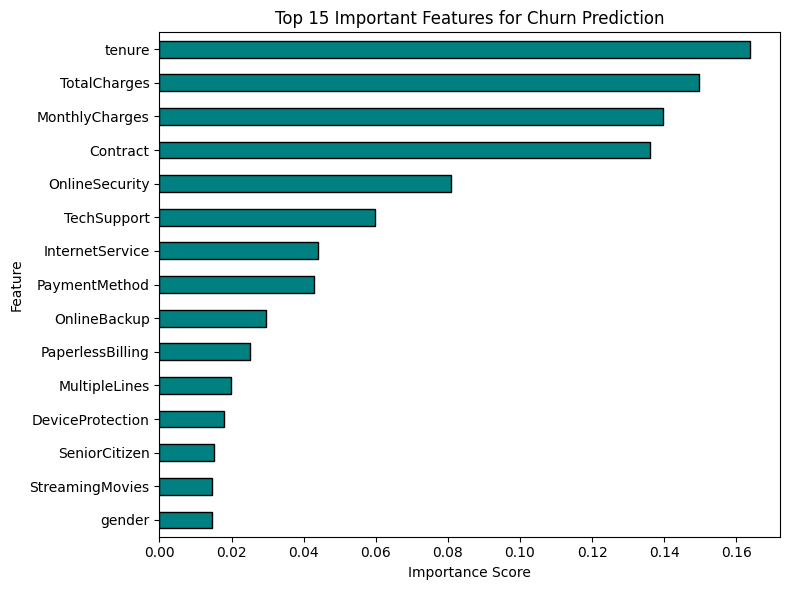

In [11]:
importances = best_rf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)

plt.figure(figsize=(8, 6))
feat_importances.sort_values().tail(15).plot(kind="barh", color="teal", edgecolor="black")
plt.title("Top 15 Important Features for Churn Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**ROC Curve**

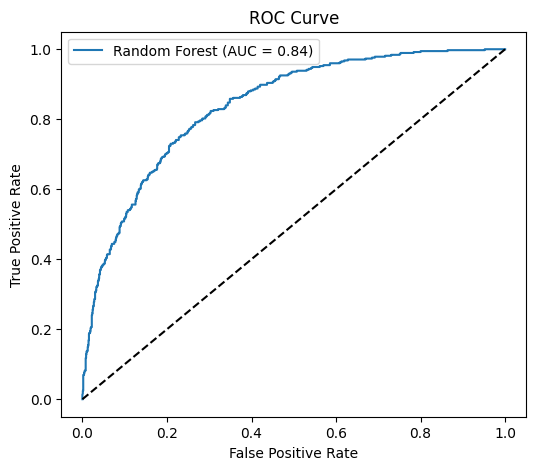

In [12]:
y_probs = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_probs):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()